In [ ]:
import numpy as py
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

#import gradio as gr

超参数调整

batch_size减小 使得运算速度逐渐变慢  但是模型测试精度有一定提升

batch_size = 64
Epoch = 20
learning_rate = 0.01
num_classes = 10
训练精度 95.92%
测试精度 65.50% 严重过拟合

batch_size = 64
Epoch = 20
learning_rate = 0.01
num_classes = 10
训练精度 74.49%
测试精度 67.45%

batch_size = 16
Epoch = 5
learning_rate = 0.01
num_classes = 10
训练精度 72.94%
测试精度 72.58%

batch_size = 16
Epoch = 10
learning_rate = 0.01
num_classes = 10
训练精度 84.10%
测试精度 75.80% 开始过拟合

batch_size = 8
Epoch = 10
learning_rate = 0.01
num_classes = 10
训练精度 77.88%
测试精度 72.12%


In [ ]:
##################################
#超参数定义
batch_size = 4
Epoch = 10
learning_rate = 0.01
num_classes = 10

In [ ]:
##################################
#输入数据处理   训练集 测试集
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                     shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                     shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
############################################
#训练集数据导入
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [ ]:
##############################
#网络定义Resnet

#定义残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):  #需要判断是否需要1×1的卷积
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                    kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                    kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                        kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        #Y += X                                                 ###############################################可以去掉 不存在残差
        return F.relu(Y)



def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*resnet_block(64, 128, 2))
        self.b4 = nn.Sequential(*resnet_block(128, 256, 2))
        self.b5 = nn.Sequential(*resnet_block(256, 512, 2))
        self.linear = nn.Linear(512, 10)
        self.Aavgpool = nn.AdaptiveAvgPool2d((1,1))





    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.Aavgpool(x)
        x = torch.flatten(x,1)
        x = self.linear(x)

        return x

net = Net()

In [ ]:
##########################
#定义损失函数 和 梯度计算

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [ ]:
#GPU训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Sat Jul  8 05:59:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   1429MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [96]:
###########################
#训练过程

#GPU训练
#net.to(device)
net = net.cuda()
#存储损失与精度
loss_history = []
accuracy_history = []


for epoch in range(Epoch):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        #获取输入

        inputs, labels = data
        #inputs.to(device)
        inputs = inputs.cuda()
        #labels.to(device)
        labels = labels.cuda()
        #梯度置零
        optimizer.zero_grad()

        #前向计算
        outputs = net(inputs)
        #获取损失
        loss = criterion(outputs, labels)
        #计算梯度
        loss.backward()
        optimizer.step()
        #累计损失
        running_loss += loss.item()
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()



        #每200次循环输出打印一次
        if i % 200 == 199:    # print every 2000 mini-batches
            print('Epoch: {}, Step: {}, Step_total: {}, Loss:{:.3f}'.format(epoch+1, i+1, len(trainloader), loss.item()))

    #计算各epoch中的平均损失值和准确率
    avg_loss = running_loss / len(trainloader)
    accuracy = 100.0 * correct_train / total_train
    #存储平均损失值和准确率
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)




print('Finished Training')


Epoch: 1, Step: 200, Step_total: 12500, Loss:2.420
Epoch: 1, Step: 400, Step_total: 12500, Loss:2.441
Epoch: 1, Step: 600, Step_total: 12500, Loss:2.518
Epoch: 1, Step: 800, Step_total: 12500, Loss:2.233
Epoch: 1, Step: 1000, Step_total: 12500, Loss:1.956
Epoch: 1, Step: 1200, Step_total: 12500, Loss:2.194
Epoch: 1, Step: 1400, Step_total: 12500, Loss:2.789
Epoch: 1, Step: 1600, Step_total: 12500, Loss:2.212
Epoch: 1, Step: 1800, Step_total: 12500, Loss:2.581
Epoch: 1, Step: 2000, Step_total: 12500, Loss:2.354
Epoch: 1, Step: 2200, Step_total: 12500, Loss:1.930
Epoch: 1, Step: 2400, Step_total: 12500, Loss:2.407
Epoch: 1, Step: 2600, Step_total: 12500, Loss:2.120
Epoch: 1, Step: 2800, Step_total: 12500, Loss:2.369
Epoch: 1, Step: 3000, Step_total: 12500, Loss:1.943
Epoch: 1, Step: 3200, Step_total: 12500, Loss:2.669
Epoch: 1, Step: 3400, Step_total: 12500, Loss:2.548
Epoch: 1, Step: 3600, Step_total: 12500, Loss:2.205
Epoch: 1, Step: 3800, Step_total: 12500, Loss:1.777
Epoch: 1, Step: 

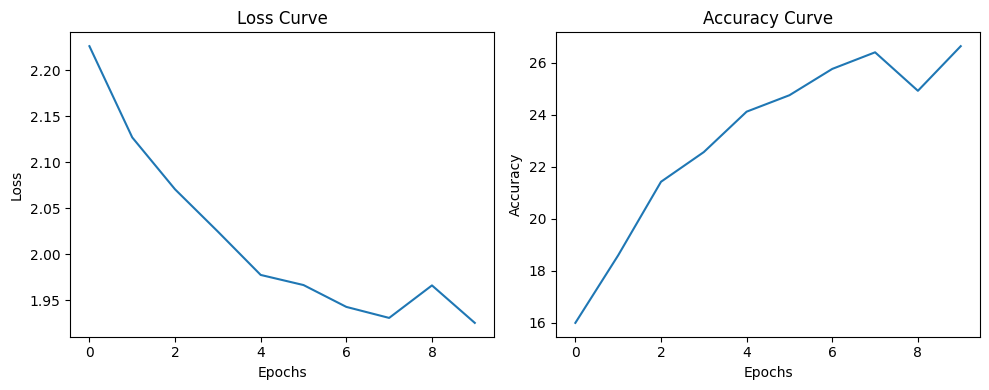

In [97]:
###############################
#绘制损失和准确率曲线

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(Epoch), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(Epoch), accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [98]:
##################################
#测试
net.eval()
#总精度及各类精度相关参数定义
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#测试数据集运行
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print('Accuracy of the net on the train iamges is {:.2f} %'.format(accuracy_history[-1]))
print('Accuracy of the net on the test iamges is {:.2f} %'.format(100 * correct / total))
print('\n')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the net on the train iamges is 26.64 %
Accuracy of the net on the test iamges is 25.34 %


Accuracy for class: plane is 25.3 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 4.7 %
Accuracy for class: cat   is 62.4 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 39.6 %
Accuracy for class: frog  is 5.9 %
Accuracy for class: horse is 2.8 %
Accuracy for class: ship  is 26.4 %
Accuracy for class: truck is 86.3 %


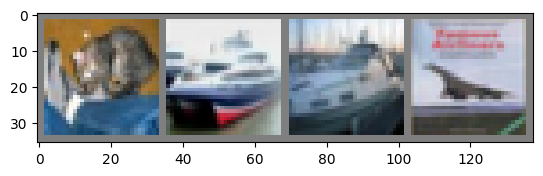

Truth Labels:  cat   ship  ship  plane
Predicted Labels:  cat   truck truck ship 


In [99]:
############################
#可视化
dataiter = iter(testloader)
images, labels = next(dataiter)

#打印测试集照片
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

#输出真实标签
print('Truth Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#输出预测标签
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted Labels: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))